Currently:
* training the original network (500-500-2000-2) on mnist with tsne loss
* training the original network on a pre-embedded set of 2d points with mse loss
* training a convolution net on a pre-embedded set of 2d points with mse loss

Next:
* check tsne loss on test set for all three models
* if we lower the learning rate in response to test set loss can we acheive lower final loss?
* what architecture allows us to minimize the number of parameters while also minimizing test tsne loss?
* does dropout have an effect on the generalization of any of the models?
* can we "deep dream" a point in 2d space to recover an input that produces it?
* what happens if we permute the input data but use the same joint probabilities?
* what if we instead use P from an unsupervised mid-dimensional representation like an autoencoder or VAE? (e.g., 48D)
* what if we use t-SNE loss as a contributing cost function to an autoencoder?

In [3]:
!nvidia-smi

Fri Jul 31 22:51:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    70W / 149W |     21MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [4]:
import os
os.environ['THEANO_FLAGS'] = 'device=gpu1'

In [5]:
!pip install keras==1.2
!pip install tensorflow-gpu==1.14

You should consider upgrading via the '/home/jiajunb/miniconda3/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/jiajunb/miniconda3/bin/python3 -m pip install --upgrade pip' command.


In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.objectives import categorical_crossentropy
from keras.datasets import mnist

from scipy.spatial.distance import pdist
import torch

from matplotlib.lines import Line2D


Using TensorFlow backend.
/home/jiajunb/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jiajunb/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jiajunb/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jiajunb/miniconda3/lib/python3.7/site-packag

In [27]:
batch_size = 5000

%time (X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

CPU times: user 1.23 s, sys: 282 ms, total: 1.51 s
Wall time: 1.51 s
60000 train samples
10000 test samples


In [28]:
def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(np.multiply(D, P)) / sumP
    P = P / sumP
    return H, P

def x2p(X, u=15, tol=1e-4, print_iter=500, max_tries=50, verbose=0):
    # Initialize some variables
    n = X.shape[0]                     # number of instances
    P = np.zeros((n, n))               # empty probability matrix
    beta = np.ones(n)                  # empty precision vector
    logU = np.log(u)                   # log of perplexity (= entropy)
    
    # Compute pairwise distances
    if verbose > 0: print('Computing pairwise distances...')
    sum_X = np.sum(np.square(X), axis=1)
    # note: translating sum_X' from matlab to numpy means using reshape to add a dimension
    D = sum_X + sum_X[:,None] + -2 * X.dot(X.T)

    # Run over all datapoints
    if verbose > 0: print('Computing P-values...')
    for i in range(n):
        
        if verbose > 1 and print_iter and i % print_iter == 0:
            print('Computed P-values {} of {} datapoints...'.format(i, n))
        
        # Set minimum and maximum values for precision
        betamin = float('-inf')
        betamax = float('+inf')
        
        # Compute the Gaussian kernel and entropy for the current precision
        indices = np.concatenate((np.arange(0, i), np.arange(i + 1, n)))
        Di = D[i, indices]
        H, thisP = Hbeta(Di, beta[i])
        
        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while abs(Hdiff) > tol and tries < max_tries:
            
            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i]
                if np.isinf(betamax):
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i]
                if np.isinf(betamin):
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
            
            # Recompute the values
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        
        # Set the final row of P
        P[i, indices] = thisP
        
    if verbose > 0: 
        print('Mean value of sigma: {}'.format(np.mean(np.sqrt(1 / beta))))
        print('Minimum value of sigma: {}'.format(np.min(np.sqrt(1 / beta))))
        print('Maximum value of sigma: {}'.format(np.max(np.sqrt(1 / beta))))
    
    return P, beta

def compute_joint_probabilities(samples, batch_size=5000, d=2, perplexity=30, tol=1e-5, verbose=0):
    v = d - 1
    
    # Initialize some variables
    n = samples.shape[0]
    batch_size = min(batch_size, n)
    
    # Precompute joint probabilities for all batches
    if verbose > 0: print('Precomputing P-values...')
    batch_count = int(n / batch_size)
    P = np.zeros((batch_count, batch_size, batch_size))
    for i, start in enumerate(range(0, n - batch_size + 1, batch_size)):   
        curX = samples[start:start+batch_size]                   # select batch
        P[i], beta = x2p(curX, perplexity, tol, verbose=verbose) # compute affinities using fixed perplexity
        P[i][np.isnan(P[i])] = 0                                 # make sure we don't have NaN's
        P[i] = (P[i] + P[i].T) # / 2                             # make symmetric
        P[i] = P[i] / P[i].sum()                                 # obtain estimation of joint probabilities
        P[i] = np.maximum(P[i], np.finfo(P[i].dtype).eps)

    return P

In [29]:
# %time P = compute_joint_probabilities(X_train, batch_size=batch_size, verbose=2)

In [30]:
# %time np.save('P.npy', P)
%time P = np.load('P.npy')

CPU times: user 1.1 ms, sys: 966 ms, total: 967 ms
Wall time: 965 ms


In [31]:
# P is the joint probabilities for this batch (Keras loss functions call this y_true)
# activations is the low-dimensional output (Keras loss functions call this y_pred)
def tsne(P, activations):
#     d = K.shape(activations)[1]
    d = 2 # TODO: should set this automatically, but the above is very slow for some reason
    n = batch_size # TODO: should set this automatically
    v = d - 1.
    eps = K.variable(10e-15) # needs to be at least 10e-8 to get anything after Q /= K.sum(Q)
    sum_act = K.sum(K.square(activations), axis=1)
    Q = K.reshape(sum_act, [-1, 1]) + -2 * K.dot(activations, K.transpose(activations))
    Q = (sum_act + Q) / v
    Q = K.pow(1 + Q, -(v + 1) / 2)
    Q *= K.variable(1 - np.eye(n))
    Q /= K.sum(Q)
    Q = K.maximum(Q, eps)
    C = K.log((P + eps) / (Q + eps))
    C = K.sum(P * C)
    return C

In [32]:
model = keras.models.Sequential()
model.add(Dense(500, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(500, activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(2))
sgd = SGD(lr=0.1)
%time model.compile(loss=tsne, optimizer=sgd)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
keep_dims is deprecated, use keepdims instead

CPU times: user 515 ms, sys: 580 ms, total: 1.1 s
Wall time: 1.09 s


In [33]:
Y_train = P.reshape(X_train.shape[0], -1)
print(X_train.shape)
print(Y_train.shape)

(60000, 784)
(60000, 5000)


In [34]:
%time model.fit(X_train, Y_train, batch_size=batch_size, shuffle=False, nb_epoch=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100


60000/60000 [==============================] - 20s - loss: 4.7510    
Epoch 2/100
60000/60000 [==============================] - 14s - loss: 3.8506    
Epoch 3/100
60000/60000 [==============================] - 14s - loss: 3.5603    
Epoch 4/100
60000/60000 [==============================] - 14s - loss: 3.4671    
Epoch 5/100
60000/60000 [==============================] - 14s - loss: 3.4124    
Epoch 6/100
60000/60000 [==============================] - 14s - loss: 3.3722    
Epoch 7/100
60000/60000 [==============================] - 14s - loss: 3.3388    
Epoch 8/100
60000/60000 [==============================] - 14s - loss: 3.3087    
Epoch 9/100
60000/60000 [==============================] - 13s - loss: 3.2805    
Epoch 10/100
60000/60000 [==============================] - 14s - loss: 3.2537    
Epoch 11/100
60000/60000 [==============================] - 13s - loss: 3.2279    

60000/60000 [==============================] - 14s - loss: 2.4089    
Epoch 89/100
60000/60000 [==============================] - 14s - loss: 2.4046    
Epoch 90/100
60000/60000 [==============================] - 14s - loss: 2.4004    
Epoch 91/100
60000/60000 [==============================] - 14s - loss: 2.3962    
Epoch 92/100
60000/60000 [==============================] - 14s - loss: 2.3921    
Epoch 93/100
60000/60000 [==============================] - 14s - loss: 2.3881    
Epoch 94/100
60000/60000 [==============================] - 14s - loss: 2.3841    
Epoch 95/100
60000/60000 [==============================] - 13s - loss: 2.3802    
Epoch 96/100
60000/60000 [==============================] - 14s - loss: 2.3764    
Epoch 97/100
60000/60000 [==============================] - 14s - loss: 2.3724    
Epoch 98/100
60000/60000 [==============================] - 13s - loss: 2.3692    
Epoch 99/100
60000/60000 [==============================] - 14s - loss: 2.3653    
Epoch 100/100
600

/home/jiajunb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


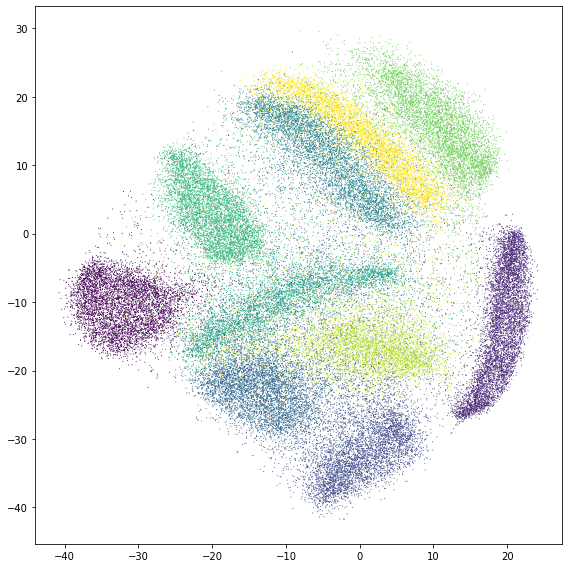

In [35]:
def plot_model(embedding, labels):
    fig = plt.figure(figsize=(8,8))
    plt.scatter(embedding[:,0], embedding[:,1], marker='o', s=1, edgecolor='', c=labels)
    fig.tight_layout()


def plot_differences(embedding, actual, lim=1000):
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    for a, b in zip(embedding, actual)[:lim]:
        ax.add_line(Line2D((a[0], b[0]), (a[1], b[1]), linewidth=1))
    ax.autoscale_view()
    plt.show()

plot_model(model.predict(X_train), y_train)

In [36]:
X_train_transformed = model.predict(X_train)
X_train_transformed_tensor = torch.from_numpy(X_train_transformed)
X_train_tensor = torch.from_numpy(X_train)

In [40]:
model.save('param-t-sne.h5')

In [37]:
# torch.save(X_train_transformed_tensor, 'X_train_transformed_tensor.torch')
# torch.save(X_train_tensor, 'X_train.torch')

In [38]:

def nearest_neighbors(x, top_k, device):
    """
    calculate the nearest neighbors of x, return the
    :param x: for matrix to calculate nearest neighbor
    :param top_k: number of the nearest neighbor to be returned
    :param device: device used during computation
    :return:
            ground_min_dist_square: torch.tensor (n, ) distance to the nearest neighbor
            topk_neighbors: torch.tensor (n, top_k) the index of the top-k nearest neighbors;
    """
    batch_size = 2001
    x = x.to(device)
    num_iter = x.shape[0] // batch_size + 1
    topk_neighbors_list = list()
    ground_min_dist_square_list = list()
    sorted_dist_list = list()
    for i in torch.arange(num_iter):
        print(f"processing {(i + 1) * batch_size} / {x.shape[0]}")
        batch_x = x[i * batch_size: (i + 1) * batch_size, :]
        dist = torch.cdist(x1=batch_x, x2=x, p=2)  # (n, n)
        sorted_dist, indices = torch.sort(dist, dim=1, descending=False)
        batch_ground_min_dist_square = sorted_dist[:, 1]  # the 0-th column is the distance to oneself
        batch_topk_neighbors = indices[:, 1:1 + top_k]
        topk_neighbors_list.append(batch_topk_neighbors.cpu())
        ground_min_dist_square_list.append(batch_ground_min_dist_square.cpu())
        sorted_dist_list.append(sorted_dist[:, 1:1 + top_k].cpu())
    ground_min_dist_square = torch.cat(ground_min_dist_square_list, dim=0)
    topk_neighbors = torch.cat(topk_neighbors_list, dim=0)
    topk_dists = torch.cat(sorted_dist_list, dim=0)
    return ground_min_dist_square.cpu(), topk_neighbors.cpu(), topk_dists.cpu()


In [39]:
X_train_transformed_tensor = torch.load('X_train_transformed_tensor.torch')
X_train_tensor = torch.load('X_train.torch')

In [13]:
_, X_original_nn, _ = nearest_neighbors(X_train_tensor, 20, 'cuda:0')
_, X_tranformed_nn, _ = nearest_neighbors(X_train_transformed_tensor, 20, 'cuda:0')

processing 2001 / 60000
processing 4002 / 60000
processing 6003 / 60000
processing 8004 / 60000
processing 10005 / 60000
processing 12006 / 60000
processing 14007 / 60000
processing 16008 / 60000
processing 18009 / 60000
processing 20010 / 60000
processing 22011 / 60000
processing 24012 / 60000
processing 26013 / 60000
processing 28014 / 60000
processing 30015 / 60000
processing 32016 / 60000
processing 34017 / 60000
processing 36018 / 60000
processing 38019 / 60000
processing 40020 / 60000
processing 42021 / 60000
processing 44022 / 60000
processing 46023 / 60000
processing 48024 / 60000
processing 50025 / 60000
processing 52026 / 60000
processing 54027 / 60000
processing 56028 / 60000
processing 58029 / 60000
processing 60030 / 60000
processing 2001 / 60000
processing 4002 / 60000
processing 6003 / 60000
processing 8004 / 60000
processing 10005 / 60000
processing 12006 / 60000
processing 14007 / 60000
processing 16008 / 60000
processing 18009 / 60000
processing 20010 / 60000
processi

In [23]:
X_original_nn[:, 0]

tensor([32248,   639, 54197,  ..., 49032, 57075, 24241])

In [25]:
scores = dict()
for r in [1, 5, 10, 20]:
    top_predictions = X_tranformed_nn[:, :r]  # (n, r)
    scores[f'Recall@{r}'] = \
        torch.sum(top_predictions == X_original_nn[:, 0].view(-1, 1), dtype=torch.float).item() / X_original_nn.shape[0]

In [26]:
scores

{'Recall@1': 0.006316666666666667,
 'Recall@5': 0.029933333333333333,
 'Recall@10': 0.056666666666666664,
 'Recall@20': 0.10341666666666667}

In [ ]:
# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, n_iter=2000, method='exact', perplexity=30, verbose=2, random_state=42)
# actual = model.fit_transform(X_train)

# plot_differences(actual, model.predict(X_train))

In [ ]:
# P.shape

In [ ]:
# x_train_dist

In [ ]:

def nearest_neighbors(x, top_k, device):
    """
    calculate the nearest neighbors of x, return the
    :param x: for matrix to calculate nearest neighbor
    :param top_k: number of the nearest neighbor to be returned
    :param device: device used during computation
    :return:
            ground_min_dist_square: torch.tensor (n, ) distance to the nearest neighbor
            topk_neighbors: torch.tensor (n, top_k) the index of the top-k nearest neighbors;
    """
    batch_size = 2000
    x = x.to(device)
    if x.shape[0] * x.shape[1] < batch_size * 200:  # direct computes the whole matrix
        dist = torch.cdist(x1=x, x2=x, p=2)  # (n, n)
        sorted_dist, indices = torch.sort(dist, dim=1, descending=False)
        ground_min_dist_square = sorted_dist[:, 1]  # the 0-th column is the distance to oneself
        topk_neighbors = indices[:, 1:1 + top_k]
        topk_dists = sorted_dist[:, 1:1 + top_k]
    else:  # calculate the nearest neighbors in batches
        num_iter = x.shape[0] // batch_size + 1
        topk_neighbors_list = list()
        ground_min_dist_square_list = list()
        sorted_dist_list = list()
        for i in tqdm(torch.arange(num_iter), desc='computing nearest neighbors'):
            batch_x = x[i * batch_size: (i + 1) * batch_size, :]
            dist = torch.cdist(x1=batch_x, x2=x, p=2)  # (n, n)
            sorted_dist, indices = torch.sort(dist, dim=1, descending=False)
            batch_ground_min_dist_square = sorted_dist[:, 1]  # the 0-th column is the distance to oneself
            batch_topk_neighbors = indices[:, 1:1 + top_k]
            topk_neighbors_list.append(batch_topk_neighbors.cpu())
            ground_min_dist_square_list.append(batch_ground_min_dist_square.cpu())
            sorted_dist_list.append(sorted_dist[:, 1:1 + top_k].cpu())
        ground_min_dist_square = torch.cat(ground_min_dist_square_list, dim=0)
        topk_neighbors = torch.cat(topk_neighbors_list, dim=0)
        topk_dists = torch.cat(sorted_dist_list, dim=0)
    return ground_min_dist_square.cpu(), topk_neighbors.cpu(), topk_dists.cpu()


In [ ]:
from tsne import bh_sne
%time X_2d = bh_sne(X_train.astype(np.float64))

In [ ]:
# %time np.save('X_2d.npy', X_2d)
# %time X_2d = np.load('X_2d.npy')
X_2d.shape

In [ ]:
# around 1.2M parameters
encoder = Sequential()
encoder.add(Dense(500, activation='relu', input_shape=(X_train.shape[1],)))
encoder.add(Dense(500, activation='relu'))
encoder.add(Dense(2000, activation='relu'))
encoder.add(Dense(2))
%time encoder.compile(loss='mse', optimizer='rmsprop')

In [ ]:
%time encoder.fit(X_train, X_2d, nb_epoch=100, verbose=2)

In [ ]:
plot_model(encoder.predict(X_train), y_train)

In [ ]:
plot_differences(encoder.predict(X_train), X_2d)

In [ ]:
# around 600K parameters
nb_filters = 32
nb_pool = 2
nb_conv = 3
conv = Sequential()
conv.add(Convolution2D(nb_filters, nb_conv, nb_conv, input_shape=(1, 28, 28)))
conv.add(Activation('relu'))
conv.add(Convolution2D(nb_filters, nb_conv, nb_conv))
conv.add(Activation('relu'))
conv.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
conv.add(Dropout(0.25))
conv.add(Flatten())
conv.add(Dense(128))
conv.add(Activation('relu'))
conv.add(Dense(2))
%time conv.compile(loss='mean_squared_error', optimizer='rmsprop')

In [ ]:
X_train_conv = X_train.reshape(-1, 1, 28, 28)
%time conv.fit(X_train_conv, X_2d, nb_epoch=100)

In [ ]:
plot_model(conv, X_train_conv, y_train)

In [ ]:
plot_differences(conv, X_train_conv, X_2d)

In [ ]:
# around 1.2M parameters
decoder = Sequential()
decoder.add(Dense(2000, activation='relu', input_shape=(2,)))
decoder.add(Dense(500, activation='relu'))
decoder.add(Dense(500, activation='relu'))
decoder.add(Dense(X_train.shape[1]))
%time decoder.compile(loss='mse', optimizer='rmsprop')

In [ ]:
%time decoder.fit(X_2d, X_train, nb_epoch=100, verbose=2)

In [ ]:
def make_mosaic(images_flat, n):
    nx = ny = n
    w = h = int(np.sqrt(len(images_flat[0])))
    images = images_flat.reshape(-1, h, w)
    image_gen = iter(images)
    mosaic = np.empty((h*ny, w*nx))
    for i in range(ny):
        for j in range(nx):
            mosaic[(nx-i-1)*w:(nx-i)*w, j*h:(j+1)*h] = next(image_gen)
    return mosaic

from cStringIO import StringIO
import PIL.Image
import IPython.display
import shutil
def showarray(a, fmt='png', filename=None):
    a = np.uint8(np.clip(a, 0, 255))
    image_data = StringIO()
    PIL.Image.fromarray(a).save(image_data, fmt)
    IPython.display.display(IPython.display.Image(data=image_data.getvalue()))
    if filename is not None:
        with open(filename, 'w') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)

In [ ]:
showarray(255 * make_mosaic(X_train, 12))
showarray(255 * make_mosaic(decoder.predict(X_2d), 12))

In [ ]:
n = X_train.shape[1]
ae = Sequential()
ae.add(Dense(500, activation='relu', weights=encoder.layers[0].get_weights(), input_shape=(n,)))
ae.add(Dense(500, activation='relu', weights=encoder.layers[1].get_weights()))
ae.add(Dense(2000, activation='relu', weights=encoder.layers[2].get_weights()))
ae.add(Dense(2, weights=encoder.layers[3].get_weights()))
ae.add(Dense(2000, activation='relu', weights=decoder.layers[0].get_weights()))
ae.add(Dense(500, activation='relu', weights=decoder.layers[1].get_weights()))
ae.add(Dense(500, activation='relu', weights=decoder.layers[2].get_weights()))
ae.add(Dense(n, weights=decoder.layers[3].get_weights()))
%time ae.compile(loss='mse', optimizer='rmsprop')

In [ ]:
%time ae.fit(X_train, X_train, nb_epoch=100, verbose=2, batch_size=32)

In [ ]:
decoded = ae.predict(X_train)
showarray(255 * make_mosaic(decoded, 12))

In [ ]:
import theano
def get_submodel(model, start, end):
    return theano.function([model.layers[start].input],
                          model.layers[end].get_output(train=False),
                          allow_input_downcast=True)
def get_encoder(ae):
    return get_submodel(ae, 0, (len(ae.layers) / 2) - 1)
def get_decoder(ae):
    return get_submodel(ae, len(ae.layers) / 2, (len(ae.layers) / 2) - 1) # this doesn't work

In [ ]:
ae_encoder = get_encoder(ae)
# ae_decoder = get_decoder(ae)

In [ ]:
encoded = encoder.predict(X_train)
ae_encoded = ae_encoder(X_train)

In [ ]:
plot_differences(encoded, ae_encoded, lim=1000)

In [ ]:
plot_model(encoded, y_train)

In [ ]:
plot_model(ae_encoded, y_train)

In [ ]:
ae_decoder = Sequential()
ae_decoder.add(Dense(2000, activation='relu', weights=ae.layers[4].get_weights(), input_shape=(2,)))
ae_decoder.add(Dense(500, activation='relu', weights=ae.layers[5].get_weights()))
ae_decoder.add(Dense(500, activation='relu', weights=ae.layers[6].get_weights()))
ae_decoder.add(Dense(X_train.shape[1], weights=ae.layers[7].get_weights()))
%time ae_decoder.compile(loss='mse', optimizer='rmsprop')

In [ ]:
def sample_grid(model, example_data, filename=None, n=128):
    x = np.linspace(example_data[:,0].min(), example_data[:,0].max(), n)
    y = np.linspace(example_data[:,1].min(), example_data[:,1].max(), n)
    xv, yv = np.meshgrid(x, y)
    samples_encoded = np.array(zip(xv.flatten(), yv.flatten()))
    samples_decoded = model.predict(samples_encoded)
    showarray(255 * make_mosaic(samples_decoded, n), filename=filename)

In [ ]:
sample_grid(decoder, encoded, filename='output-orig.png')

In [ ]:
sample_grid(ae_decoder, ae_encoded, filename='output-finer.png')

In [ ]:
n = X_train.shape[1]
ae_scratch = Sequential()
ae_scratch.add(Dense(500, activation='relu', input_shape=(n,)))
ae_scratch.add(Dense(500, activation='relu'))
ae_scratch.add(Dense(2000, activation='relu'))
ae_scratch.add(Dense(2))
ae_scratch.add(Dense(2000, activation='relu'))
ae_scratch.add(Dense(500, activation='relu'))
ae_scratch.add(Dense(500, activation='relu'))
ae_scratch.add(Dense(n))
%time ae_scratch.compile(loss='mse', optimizer='rmsprop')

In [ ]:
ae_scratch.fit(X_train, X_train, nb_epoch=300, verbose=2)

In [ ]:
plt.figure(figsize=(10,6))
plt1, = plt.plot(ae_scratch.history.history['loss'][:200], label='Vanilla AE')
plt2, = plt.plot(decoder.history.history['loss'], label='t-SNE Generator')
plt3, = plt.plot(range(100, 200), ae.history.history['loss'], label='t-SNE AE')
plt.legend(handles=[plt1, plt2, plt3])
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss (MSE)')
# plt.plot(encoder.history.history['loss'])

In [ ]:
ae_scratch_encoder = get_encoder(ae_scratch)

In [ ]:
ae_scratch_encoded = ae_scratch_encoder(X_train)

In [ ]:
ae_scratch_decoder = Sequential()
ae_scratch_decoder.add(Dense(2000, activation='relu', weights=ae_scratch.layers[4].get_weights(), input_shape=(2,)))
ae_scratch_decoder.add(Dense(500, activation='relu', weights=ae_scratch.layers[5].get_weights()))
ae_scratch_decoder.add(Dense(500, activation='relu', weights=ae_scratch.layers[6].get_weights()))
ae_scratch_decoder.add(Dense(X_train.shape[1], weights=ae_scratch.layers[7].get_weights()))
%time ae_scratch_decoder.compile(loss='mse', optimizer='rmsprop')

In [ ]:
sample_grid(ae_scratch_decoder, ae_scratch_encoded, filename='output-scratch.png')